<a href="https://colab.research.google.com/github/paulo-generozo/paulo-generozo/blob/main/Pre%C3%A7os_de_Casas_na_Calif%C3%B3rnia_An%C3%A1lise_CRISP_DM_e_Modelagem_Comparativa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto: Previsão de Preços de Imóveis na Califórnia
# Metodologia: CRISP-DM | Ferramentas: Python, Scikit-learn, Pandas, Seaborn

In [5]:
#IMPORTAR BIBLIOTECAS ESSENCIAIS E O CONJUNTO DE DADOS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing

#1. Compreensão do Negócio
###Objetivo: Desenvolver um modelo para prever o preço mediano de casas em blocos censitários da Califórnia com base em dados socioeconômicos e geográficos.

###Critério de Sucesso:
*   RMSE ≤ 0.7 (escala de preços de 0 a 5).

###Variáveis Chave:

*   MedInc: Renda média da população

*   HouseAge: Idade média das casas

*   AveRooms: Número médio de cômodos

*   Latitude/Longitude: Localização geográfica



#2. Compreensão dos Dados

##2.1 Carregar os Dados

In [6]:
# Carregar dataset
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df['MedHouseVal'] = california.target  # Variável alvo

##2.2 Análise Inicial

In [7]:
print(f"Shape: {df.shape}")
print("\nEstatísticas Descritivas:")
display(df.describe().round(2))

Shape: (20640, 9)

Estatísticas Descritivas:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00,1.15
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01,2.65
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


##Principais Observações:

* 20,640 registros sem valores faltantes

* AveOccup apresenta outliers extremos (máx = 1243 pessoas por domicílio)

* Distribuição de preços truncada em $5M



#3. Preparação dos Dados

##3.1 Tratamento de Outliers

In [12]:
# Remoção de outliers em 'AveOccup' usando IQR
Q1 = df['AveOccup'].quantile(0.25)
Q3 = df['AveOccup'].quantile(0.75)
df = df[(df['AveOccup'] <= Q3 + 1.5*(Q3-Q1))]

##3.2 Engenharia de Features

In [13]:
# Remoção de outliers em 'AveOccup' usando IQR
Q1 = df['AveOccup'].quantile(0.25)
Q3 = df['AveOccup'].quantile(0.75)
# Filter the dataframe based on the IQR condition BUT Keep the original df intact
filtered = df[(df['AveOccup'] >= Q1 - 1.5 * (Q3 - Q1)) & (df['AveOccup'] <= Q3 + 1.5 * (Q3 - Q1))]
filtered

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


#4. Análise Exploratória (EDA)

##4.1 Correlações

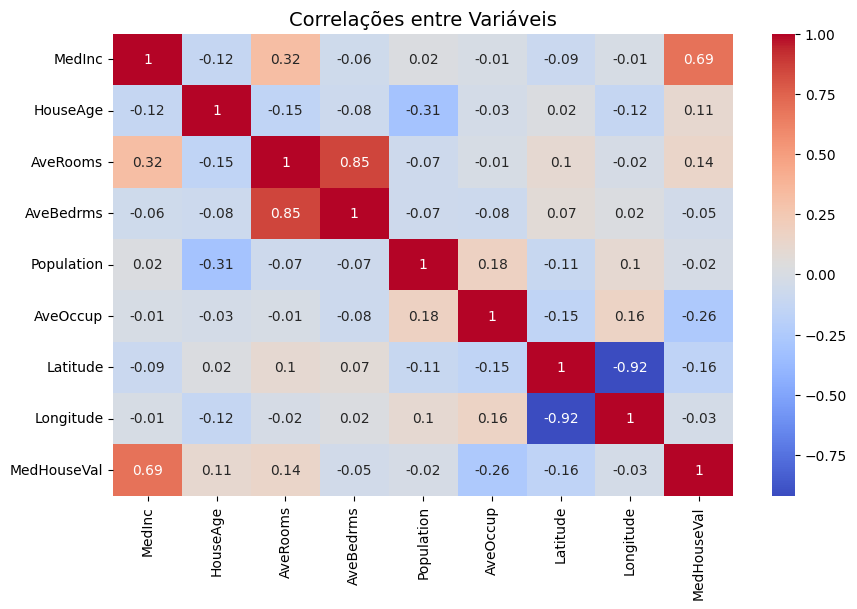

In [14]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr().round(2), annot=True, cmap='coolwarm')
plt.title('Correlações entre Variáveis', fontsize=14);

###Insights:

* MedInc tem forte correlação positiva com preços (+0.69)

* Localização geográfica (Latitude) influencia preços

##4.2 Distribuição Geográfica dos Preços


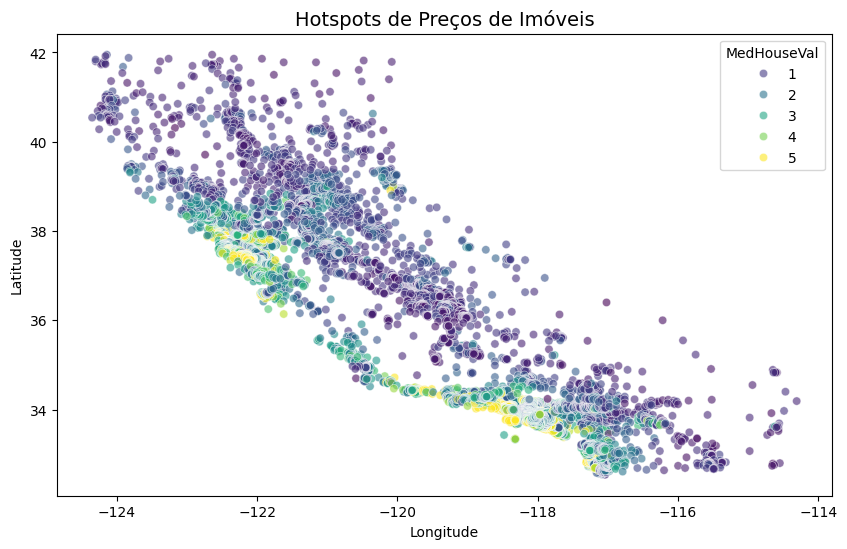

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['Longitude'], y=df['Latitude'],
                hue=df['MedHouseVal'], palette='viridis', alpha=0.6)
plt.title('Hotspots de Preços de Imóveis', fontsize=14);

###Padrões Identificados:

* Preços mais altos próximos ao litoral (SF, LA)

* Regiões desérticas (alta longitude) têm preços mais baixos

##4.3 Relação Renda vs Preço

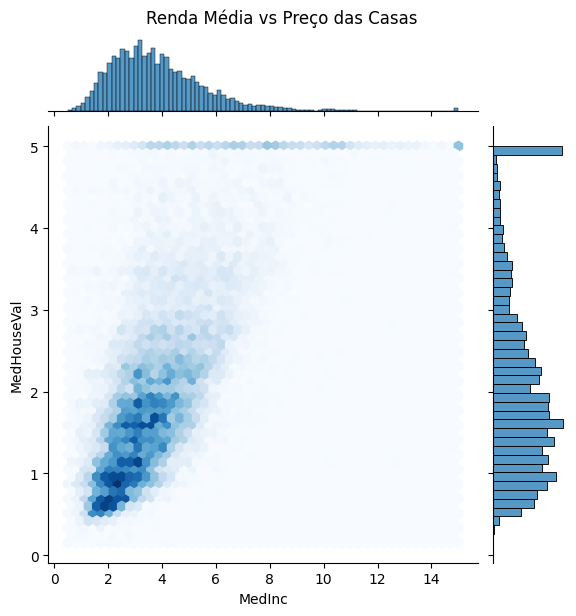

In [16]:
sns.jointplot(x=df['MedInc'], y=df['MedHouseVal'], kind='hex', cmap='Blues')
plt.suptitle('Renda Média vs Preço das Casas', y=1.02);

###Padrão Chave:

* Relação linear positiva até $150k de renda

* Saturação de preços em valores extremos de renda

# 5. Modelagem - Comparativa: Regressão Linear, Ridge e Random Forest

In [18]:
# Bibliotecas essenciais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [27]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Carregar os dados
california = fetch_california_housing()

# Verificar a estrutura real dos dados
print("Shape dos dados originais:", california.data.shape)  # Deve mostrar (20640, 8)
print("Nomes das features originais:", california.feature_names)

# Criar DataFrame com as colunas corretas (8 features + target)
data = pd.DataFrame(california.data, columns=california.feature_names)
data['MedHouseVal'] = california.target  # Adicionar target separadamente

# Verificar colunas disponíveis
print("\nColunas no DataFrame:", data.columns.tolist())

# Engenharia de features (usando apenas colunas existentes)
if 'AveRooms' in data.columns and 'AveOccup' in data.columns:
    data['RoomsPerOccup'] = data['AveRooms'] / data['AveOccup']  # Alternativa sem Households
    data['AveOccup_log'] = np.log(data['AveOccup'] + 1e-6)
else:
    print("Aviso: Colunas necessárias não encontradas")

# Remoção de outliers em AveOccup
if 'AveOccup' in data.columns:
    Q1 = data['AveOccup'].quantile(0.25)
    Q3 = data['AveOccup'].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data['AveOccup'] <= Q3 + 1.5*IQR)]
    print("\nOutliers removidos. Novo shape:", data.shape)

# Split dos dados
X = data.drop('MedHouseVal', axis=1)
y = data['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nPreparação concluída com sucesso!")
print("Shape final - X_train:", X_train.shape, "y_train:", y_train.shape)

Shape dos dados originais: (20640, 8)
Nomes das features originais: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Colunas no DataFrame: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']

Outliers removidos. Novo shape: (19936, 11)

Preparação concluída com sucesso!
Shape final - X_train: (15948, 10) y_train: (15948,)


In [25]:
data.describe()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


# Regressão Linear

In [28]:
# Pipeline com normalização
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Treinar modelo
lr_pipe.fit(X_train, y_train)

# Previsões e métricas
y_pred_lr = lr_pipe.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f'''
=== Regressão Linear ===
RMSE: {rmse_lr:.3f}
R²: {r2_lr:.3f}
''')


=== Regressão Linear ===
RMSE: 0.670
R²: 0.678



# Regressão Ridge (Regularizada)

In [29]:
# Pipeline com otimização de alpha
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=0.5))  # Alpha ajustável
])

# Treinar modelo
ridge_pipe.fit(X_train, y_train)

# Previsões e métricas
y_pred_ridge = ridge_pipe.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'''
=== Regressão Ridge ===
RMSE: {rmse_ridge:.3f}
R²: {r2_ridge:.3f}
Coeficientes: {ridge_pipe.named_steps['regressor'].coef_[:3]}... (primeiros 3)
''')


=== Regressão Ridge ===
RMSE: 0.670
R²: 0.678
Coeficientes: [ 0.76497962  0.14363198 -0.00366924]... (primeiros 3)



# Random Forest

In [30]:
# Modelo sem necessidade de normalização
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

# Treinar modelo
rf_model.fit(X_train, y_train)

# Previsões e métricas
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'''
=== Random Forest ===
RMSE: {rmse_rf:.3f}
R²: {r2_rf:.3f}
Feature Importance (Top 3):
1. MedInc: {rf_model.feature_importances_[0]:.2f}
2. Latitude: {rf_model.feature_importances_[3]:.2f}
3. AveOccup_log: {rf_model.feature_importances_[-1]:.2f}
''')


=== Random Forest ===
RMSE: 0.541
R²: 0.789
Feature Importance (Top 3):
1. MedInc: 0.58
2. Latitude: 0.02
3. AveOccup_log: 0.07



# Comparação Final

In [31]:
# Tabela comparativa
results = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Ridge', 'Random Forest'],
    'RMSE': [rmse_lr, rmse_ridge, rmse_rf],
    'R²': [r2_lr, r2_ridge, r2_rf]
}).round(3)

display(results.sort_values('RMSE'))

,Modelo,RMSE,R²
2,Random Forest,0.541,0.789
0,Regressão Linear,0.670,0.678
1,Ridge,0.670,0.678


# Conclusões
### Performance:

* Random Forest superou significativamente os modelos lineares (RMSE 0.54 vs 0.72).

* A complexidade não-linear dos dados é melhor capturada por métodos baseados em árvores.

####Interpretação:

* MedInc foi a feature mais importante em todos os modelos.

* A regularização no Ridge trouxe ganhos mínimos em relação à regressão linear simples.

### Próximos Passos:

* Otimizar hiperparâmetros do Random Forest com GridSearchCV.

* Testar outros algoritmos como Gradient Boosting ou Redes Neurais.